In [1]:
import numpy as np
import tensorflow as tf
import cv2
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm

In [2]:
model_path = "Models/3_model_vgg.h5"  
model = load_model(model_path)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 21,139,269 (80.64 MB)

 Trainable params: 21,138,755 (80.64 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 2 (12.00 B)

In [3]:
def load_and_preprocess_images(image_folder, target_size=(224, 224)):
    X_test, y_test = [], []
    class_labels = sorted(os.listdir(image_folder))  # Sorting ensures label consistency

    for label in class_labels:
        class_path = os.path.join(image_folder, label)
        if not os.path.isdir(class_path):
            continue

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            image = cv2.imread(image_path)
            if image is None:
                print(f"Skipping {image_path}, unable to load.")
                continue

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, target_size)
            image = img_to_array(image).astype("float32") / 255.0  # Normalize
            X_test.append(image)
            y_test.append(label)

    return np.array(X_test), np.array(y_test), class_labels

In [4]:
test_folder = "test" 
X_test, y_test, class_labels = load_and_preprocess_images(test_folder)

X_test = X_test.reshape(-1, 224, 224, 3)  
label_mapping = {label: idx for idx, label in enumerate(class_labels)}
y_test_encoded = np.array([label_mapping[label] for label in y_test])

In [5]:
y_pred_probs = model.predict(X_test)  # Get probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert to class index

# Compute accuracy
accuracy = accuracy_score(y_test_encoded, y_pred_classes)
print(f"\nModel Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_classes, target_names=class_labels))


10/10 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step

Model Accuracy: 0.9067

Classification Report:
               precision    recall  f1-score   support

citrus canker       1.00      0.89      0.94       100
      healthy       0.78      1.00      0.88       100
     melanose       1.00      0.83      0.91       100

     accuracy                           0.91       300
    macro avg       0.93      0.91      0.91       300
 weighted avg       0.93      0.91      0.91       300



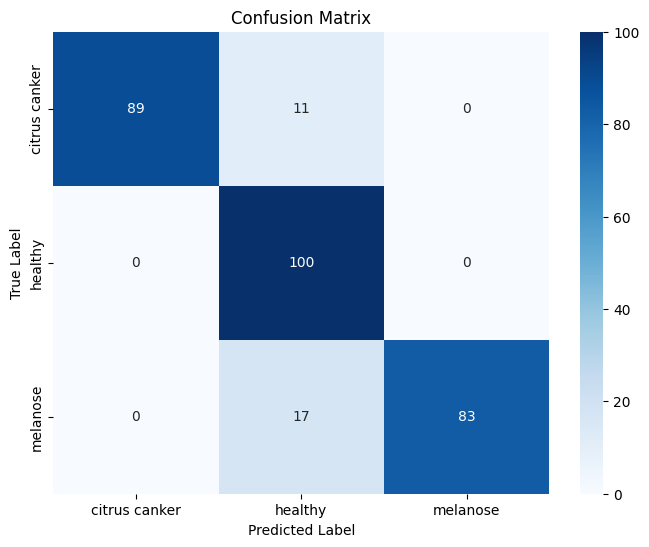

In [6]:
cm = confusion_matrix(y_test_encoded, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()